## **Controllable Generation**

In Controllable Generation, we manipulate the noise vectors' input to generate certain features more or less. We use the CelebA dataset for this GAN.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import make_grid
import torchvision.datasets as datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import seaborn as sn
from google.colab import drive

In [2]:
def show(images, n_images, nrows):
  grid = make_grid(((images + 1) / 2).detach().cpu()[:n_images], nrow=nrows)
  plt.imshow(grid.permute(1,2,0).squeeze())
  plt.show()

In [3]:
image_hw = 64
transform = transforms.Compose([
    transforms.Resize(image_hw),
    transforms.CenterCrop(image_hw),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
dataset = datasets.CelebA('CelebA', download=True,
                          transform=transform, split='train')
data_loader = DataLoader(dataset, batch_size=128,
                         shuffle=True)

Files already downloaded and verified


## **Dataset exploration**

In [5]:
for image, labels in tqdm(data_loader):
  img = image
  lbl = labels[:, range(40)]

  0%|          | 0/1272 [00:00<?, ?it/s]

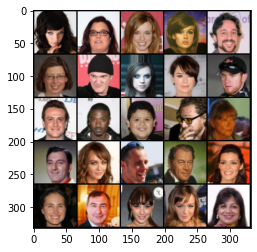

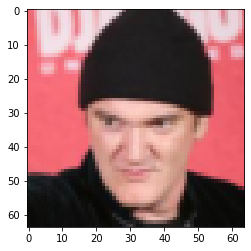

In [7]:
show(img, 25, 5)
image = 6 # Change this
show(img[image], 25, 5)

In [29]:
features = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

In [30]:
print(lbl.size())
print(lbl[image].size())
print(lbl[image])
for i in range(len(features)):
  if (lbl[image].numpy() == True)[i]:
    print(features[i])

torch.Size([82, 40])
torch.Size([40])
tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])
Attractive
Bangs
BrownHair
NoBeard
StraightHair
WearingLipstick
Young


## **Generator**

In [11]:
def generator_block(input, output, kernel_size=3, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, stride),
        nn.BatchNorm2d(output),
        nn.ReLU(inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, stride),
        nn.Tanh()
    )
  return x

In [12]:
class Generator(nn.Module):
  def __init__(self, noise_dim, image_dim, hidden_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.gen = nn.Sequential(
        generator_block(noise_dim, hidden_dim * 8),
        generator_block(hidden_dim * 8, hidden_dim * 4),
        generator_block(hidden_dim * 4, hidden_dim * 2),
        generator_block(hidden_dim * 2, hidden_dim),
        generator_block(hidden_dim, image_dim, kernel_size=4, last_layer=True)
    )
  def forward(self, noise):
    noise = noise.view(len(noise), self.noise_dim, 1, 1)
    return self.gen(noise)

In [13]:
def get_noise_vectors(n_samples, noise_dim, device='cpu'):
  return torch.randn(n_samples, noise_dim, device=device)

## **Classifier**

In [14]:
def classifier_block(input, output, kernel_size=4, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.Conv2d(input, output, kernel_size, stride),
        nn.BatchNorm2d(output),
        nn.LeakyReLU(0.2, inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.Conv2d(input, output, kernel_size, stride)
    )
  return x

In [15]:
class Classifier(nn.Module):
  def __init__(self, image_dim, classes, hidden_dim):
    super(Classifier, self).__init__()
    self.classifier = nn.Sequential(
        classifier_block(image_dim, hidden_dim),
        classifier_block(hidden_dim, hidden_dim * 2),
        classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
        classifier_block(hidden_dim * 4, classes, last_layer=True)
    )
  def forward(self, image):
    image = self.classifier(image)
    return image.view(len(image), -1)

## **Training**

In [16]:
label_idx = range(40) # Number of facial features
epochs = 50
lr = 0.0002
step = 500
beta_1 = 0.5
beta_2 = 0.999
image_size = 64
image_channels = 3
hidden_dim = 64
noise_dim = 64
device = 'cuda'
classes = 40

# generator = Generator(noise_dim, image_channels, hidden_dim).to(device)
# gen_optim = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
# classifier = Classifier(image_channels, len(label_idx), hidden_dim).to(device)
# clf_optim = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
# criterion = nn.BCEWithLogitsLoss()

# def init_weights(layer):
#   if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
#     torch.nn.init.normal_(layer.weight, 0.0, 0.02)
#   if isinstance(layer, nn.BatchNorm2d):
#     torch.nn.init.normal_(layer.weight, 0.0, 0.02)
#     torch.nn.init.constant_(layer.bias, 0)

# generator = generator.apply(init_weights)
# classifier = classifier.apply(init_weights)

In [17]:
def train_classifier(classifier, clf_optim, file, criterion):
  cur_step = 0
  clf_losses = []
  for epoch in range(epochs):
    for image, labels in tqdm(data_loader):
      image = image.to(device)
      labels = labels[:, label_idx].to(device).float()

      clf_optim.zero_grad()
      pred = classifier(image)
      loss = criterion(pred, labels)
      loss.backward()
      clf_optim.step()
      clf_losses += [loss.item()]

      if cur_step % step == 0 and cur_step > 0:
        class_mean = sum(clf_losses[-step:]) / step
        print(f"Step {cur_step}: Classifier loss: {class_mean}")
        step_bins = 20
        x_axis = sorted([i * step_bins for i in range(len(clf_losses) // step_bins)] * step_bins)
        sn.lineplot(x_axis, clf_losses[:len(x_axis)], label="Classifier Loss")
        plt.legend()
        plt.show()
        torch.save({"classifier": classifier.state_dict()}, file)
    cur_step += 1

In [18]:
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
celeba_gan = '/content/drive/MyDrive/celeba_gan.pth'
celeba_clf = '/content/drive/MyDrive/celeba_clf.pth'

In [20]:
def load_model(gen_path, clf_path):
  gen = Generator(noise_dim, image_channels, hidden_dim).to(device)
  gen_state = torch.load(gen_path, map_location=torch.device(device))['gen']
  gen.load_state_dict(gen_state)
  gen.eval()

  classifier = Classifier(image_channels, classes, hidden_dim).to(device)
  class_state = torch.load(clf_path, map_location=torch.device(device))['classifier']
  classifier.load_state_dict(class_state)
  classifier.eval()

  optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)
  return gen, classifier, optimizer

In [21]:
def grad_ascent_update_noise(weight, noise):
  noise_n = noise + (noise.grad * weight)
  return noise_n

## **Controlled Generation**

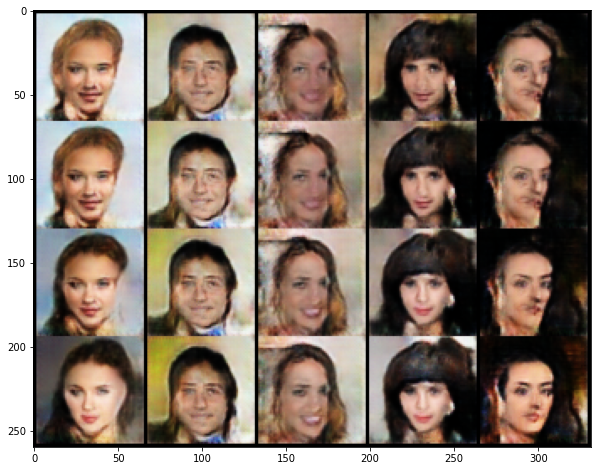

In [37]:
image = 5
step = 20
skip = 5
prev_fake_image = []

feature = features.index('Young')

gen, clf, opt = load_model(celeba_gan, celeba_clf)

noise = get_noise_vectors(image, noise_dim).to(device).requires_grad_()
for i in range(step):
  opt.zero_grad()
  fake = gen(noise)
  prev_fake_image += [fake]
  fake_cls_score = clf(fake)[:, feature].mean()
  fake_cls_score.backward()
  noise.data = grad_ascent_update_noise(1/step, noise)

plt.rcParams['figure.figsize'] = [image * 2, step * 2]
show(torch.cat(prev_fake_image[::skip], dim=2), image, image)